The purpose of this notebook is to test the following methods:
1. https://docs.cogdl.ai/en/latest/_modules/cogdl/models/emb/graph2vec.html?fbclid=IwAR0eDx4p_OjlGpb_Q2l-t2BVt3hVtqqtq6kdoABVnye3ehDJcrSEpj1XLfY
2. https://karateclub.readthedocs.io/en/latest/_modules/karateclub/graph_embedding/graph2vec.html

In [1]:
# prerequisites
# !pip install cogdl==0.1.1
# !pip install karateclub
# !pip install torch_geometric

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import json
import glob

import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
from typing import Tuple, List

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from IPython.display import Markdown, display
from tqdm.notebook import tqdm

from cogdl.models.emb.graph2vec import Graph2Vec as c_Graph2Vec
from karateclub.graph_embedding.graph2vec import Graph2Vec as k_Graph2Vec

import torch
from torch_geometric.utils.convert import from_networkx

plt.rcParams["figure.figsize"] = (16, 8)

FileNotFoundError: Could not find module 'C:\Users\Ela\anaconda3\Lib\site-packages\torch_sparse\_convert_cuda.pyd' (or one of its dependencies). Try using the full path with constructor syntax.

In [5]:
def read_stargazers_dataset(path: str) -> Tuple[List, pd.Series]:
    """
    Function to read the graphs and their labels from github Stargazers dataset.
    Args:
        path (str): path to the dataset

    Returns:
        Tuple[List,pd.Series]: A tuple consisting of a list of NetworkX graphs and a pd.Series of their respective labels
    """
    data_path = os.path.join(path, "git_edges.json")
    target_path = os.path.join(path, "git_target.csv")
    with open(data_path) as f:
        json_content = json.load(f)
    target = pd.read_csv(target_path, index_col="id").squeeze("columns")
    return [nx.Graph(elem) for key, elem in json_content.items()], target


In [3]:
torch.__version__

'1.11.0+cpu'

In [6]:
def create_logreg_model(embedding, labels, get_pred=False):
    X_train, X_test, y_train, y_test = train_test_split(
        embedding, labels, test_size=0.3
    )
    model = LogisticRegression()
    model.fit(X_train, y_train)
    if get_pred:
        return model.predict_proba(X_test), y_test
    return 1 - (np.abs(model.predict(X_test) - y_test)).mean()


In [7]:
def calculate_measure(func, G, kwargs={}):
    return func(G, **kwargs)

In [8]:
graphs, labels = read_stargazers_dataset("../datasets/github_stargazers")

len(graphs)

12725

## Parameters section

In [9]:
subset_card = 12725  # 12725  # number of graphs
expt_iter_num = 1000  # number of models to train

In [3]:
import torch

In [4]:
torch.__version__

'1.12.1'

## Execution section

In [10]:
graphs_subset = graphs[:subset_card]

order_dict = {}
c_graph2vec_dm = c_Graph2Vec(
    dimension=5,
    window_size=2,
    min_count=5,
    dm=1,
    sampling_rate=0.0001,
    rounds=2,
    lr=0.025,
    epoch=10
)
c_graph2vec_no_dm = c_Graph2Vec(
    dimension=5,
    window_size=0,
    min_count=5,
    dm=0,
    sampling_rate=0.0001,
    rounds=2,
    lr=0.025,
    epoch=10
)
k_graph2vec = k_Graph2Vec()

In [11]:
# c_graph2vec_dm.forward(graphs=graphs_subset)

  0%|          | 0/1000 [00:00<?, ?it/s]

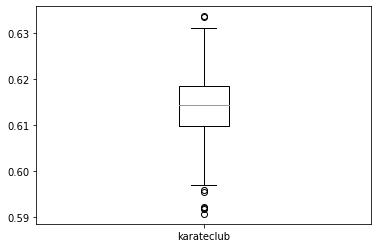

In [12]:
# in this cell we run experiments for all measures


# benchmark
# c_graph2vec_dm.forward(graphs_subset)
# c_graph2vec_no_dm.forward(graphs_subset)
k_graph2vec.fit(graphs_subset)

# # experiment
# c_no_dm_res = [0] * expt_iter_num
# c_dm_res = [0] * expt_iter_num
k_res = [0] * expt_iter_num

for it in tqdm(range(expt_iter_num)):
#     c_dm_res[it] = create_logreg_model(
#         with_dm.get_embedding(), labels=labels[:subset_card]
#     )
#     c_no_dm_res[it] = create_logreg_model(
#         without.get_embedding(), labels=labels[:subset_card]
#     )

    k_res[it] = create_logreg_model(
        k_graph2vec.get_embedding(),
        labels=labels[:subset_card]
    )
    
# results
res_nested_list = [
#     no_dm_res,
#     dm_res,
    k_res

]
axis_labels = [
#     'Skipgram',
#     'CBOW',
    'karateclub'
]

n_items = len(res_nested_list)
plt.boxplot(res_nested_list, positions=range(n_items))
plt.xticks(range(n_items), labels=axis_labels[:n_items])
plt.show()